# 星美数据生成 Ranking 数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

## 1. 从订单数据中过滤出电影 ID 与用户 ID 集合

In [2]:
user_set = set()
movie_set = set()

读取订单数据，从中提取用户 ID 与电影 ID。

In [3]:
df_order = pd.read_csv("订单.csv.gz", encoding = "gb18030", dtype = str)
order_list = df_order.loc[:, [u'会员ID', u'电影ID']].values.tolist()
for user_id, movie_id in order_list:
    if type(user_id) != float or not math.isnan(user_id):
        user_set.add(int(user_id))
    if type(movie_id) != float or not math.isnan(movie_id):
        movie_set.add(int(movie_id))

用户集合

In [4]:
print len(user_set), list(user_set)[:5]

304940 [5767171, 5767173, 6291462, 6204076, 6291469]


电影集合

In [5]:
print len(movie_set), list(movie_set)[:5]

587 [237568, 229379, 163844, 233477, 237574]


## 2. 生成场次数据

数据来源：石佳琳生成的猫眼排片数据对应表  
{begin_date：时间，“title”：{xingmei_id：[猫眼排片数目，电影名称，maoyan_id],week:周数目}

在场次数据中出现，但是没有在订单数据中出现的，计入电影 ID 集合。

In [6]:
weekly_screens = []
movie_weekly_screens = {}

In [7]:
import json
filename = "xingmeiorder_final.json"
with open(filename) as F:
    for line in F:
        screens = {}
        obj = json.loads(line)
        begin_date = "20" + obj["begin_date"]
        titles = obj["title"]
        year, month, day = map(int, begin_date.split("-"))
        begin_timestamp = (datetime(year, month, day) - datetime(1970, 1, 1)).total_seconds()
        end_timestamp = begin_timestamp + 7 * 24 * 60 * 60
        screens["begin"] = begin_timestamp
        screens["end"] = end_timestamp
        d = {}
        for xingmei_id in titles:
            movie_id = int(xingmei_id)
            movie_set.add(movie_id)
            screen_count = titles[xingmei_id][0]
            d[movie_id] = screen_count
            if movie_id not in movie_weekly_screens:
                movie_weekly_screens[movie_id] = []
            movie_weekly_screens[movie_id].append(screen_count)
        screens["screens"] = d
        weekly_screens.append(screens)

电影的第一周票房

In [8]:
first_week_screens = {}
for m in movie_weekly_screens:
    for c in movie_weekly_screens[m]:
        if m in first_week_screens:
            if c > 10 * first_week_screens[m]:
                first_week_screens[m] = c
        else:
            first_week_screens[m] = c

26
618021


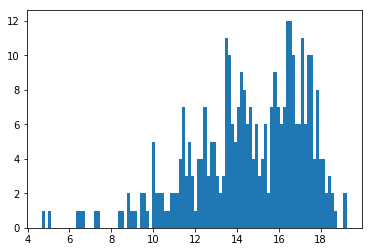

In [9]:
print min(first_week_screens.values())
print max(first_week_screens.values())
log2 = lambda x: math.log(x, 2)
plt.hist(map(log2, first_week_screens.values()), bins = 100)
plt.show()

In [10]:
def get_screens(movie_id):
    if movie_id not in first_week_screens:
        return "screens:<2000"
    else:
        sc = first_week_screens[movie_id] / 1000
        log2 = lambda x: int(math.log(x, 2))
        if sc <= 0 or log2(sc) < 1:
            return "screens:<%d000" % (2**1)
        elif log2(sc) < 2:
            return "screens:%d000-%d000" % (2**1, 2**2)
        elif log2(sc) < 3:
            return "screens:%d000-%d000" % (2**2, 2**3)
        elif log2(sc) < 4:
            return "screens:%d000-%d000" % (2**3, 2**4)
        elif log2(sc) < 5:
            return "screens:%d000-%d000" % (2**4, 2**5)
        elif log2(sc) < 6:
            return "screens:%d000-%d000" % (2**5, 2**6)
        elif log2(sc) < 7:
            return "screens:%d000-%d000" % (2**6, 2**7)
        elif log2(sc) < 8:
            return "screens:%d000-%d000" % (2**7, 2**8)
        else:
            return "screens:>%d000" % (2**8)

debug

In [11]:
for m in movie_weekly_screens:
    print get_screens(m), first_week_screens[m], "----",
    for c in movie_weekly_screens[m]:
        print c,
    print ""

screens:128000-256000 228961 ---- 228961 443000 289000 181000 73999 
screens:64000-128000 97488 ---- 97488 122423 32551 211 
screens:16000-32000 23735 ---- 23735 13578 2747 
screens:64000-128000 110142 ---- 1 110142 152000 20127 5820 
screens:16000-32000 23717 ---- 23717 17283 
screens:<2000 1951 ---- 1951 
screens:64000-128000 74601 ---- 2 34 74601 109535 27293 5562 1664 
screens:128000-256000 173077 ---- 173077 265000 95667 23725 10492 
screens:128000-256000 137483 ---- 137483 282000 81077 19968 5580 
screens:16000-32000 20351 ---- 20351 35693 14355 2473 755 
screens:2000-4000 2841 ---- 2841 1689 4790 1471 
screens:<2000 151 ---- 151 55 13 
screens:32000-64000 60167 ---- 60167 50234 1970 
screens:<2000 160 ---- 160 
screens:32000-64000 40514 ---- 18 40514 
screens:128000-256000 165403 ---- 165403 163314 42974 5824 1490 
screens:4000-8000 7136 ---- 7136 6768 593 
screens:16000-32000 19042 ---- 19042 1453 
screens:4000-8000 6686 ---- 6686 1174 
screens:128000-256000 245119 ---- 245119 

In [12]:
from collections import defaultdict
screen_count_dict = defaultdict(int)
for m in movie_weekly_screens:
    screen_count_dict[get_screens(m)] += 1
print screen_count_dict

defaultdict(<type 'int'>, {'screens:>256000': 18, 'screens:64000-128000': 60, 'screens:32000-64000': 37, 'screens:2000-4000': 26, 'screens:8000-16000': 40, 'screens:<2000': 33, 'screens:128000-256000': 52, 'screens:16000-32000': 45, 'screens:4000-8000': 28})


## 3. 生成电影的 tag 列表

星美 ID ： tag 列表

In [13]:
movie_tags = {}

In [14]:
df_movie = pd.read_csv("影片.csv.gz", encoding = "gb18030", dtype = str)
L = df_movie.loc[:, [u'影片ID', u'影片名称', u'影片英文名', u'发行国家', u'影片类型', u'年份', u'导演', u'导演评分', u'主演演员', u'发行公司']].values.tolist()
for item_id, chi_name, eng_name, country, genre, year, director, director_rating, actor, company in L:
    l = item_id, chi_name, eng_name, country, genre, year, director, director_rating, actor, company
    if int(item_id) in movie_set:
        l = [u'null' if type(item) == float and math.isnan(item) else item for item in l]
        item_id, chi_name, eng_name, country, genre, year, director, director_rating, actor, company = l
        get_items = lambda s: [item.strip() for item in s.strip("/").split("/")]
        tag_list = []
        for item in get_items(country):
            tag_list.append(u"country:" + item)
        for item in get_items(genre):
            tag_list.append(u"genre:" + item)
        for item in get_items(year):
            tag_list.append(u"year:" + item)
        for item in get_items(director):
            tag_list.append(u"director:" + item)
        for item in get_items(director_rating):
            if item != u'null':
                tag_list.append(u"director_rating:" + str(int(float(item))))
            else:
                tag_list.append(u"director_rating:" + str(item))
        for item in get_items(actor):
            tag_list.append(u"actor:" + item)
        for item in get_items(company):
            tag_list.append(u"company:" + item)
        tag_list.append(get_screens(int(item_id)))
        movie_tags[int(item_id)] = tag_list

In [15]:
print len(movie_tags)
print movie_tags.items()[:5]

587
[(237568, [u'country:\u4e2d\u56fd', u'genre:\u7eaa\u5f55\u7247', u'year:2016', u'director:\u53f6\u541b Jun Ye', u'director:\u8427\u5bd2 Han Xiao', u'director_rating:0', u'actor:\u738b\u6d25 Jin Wang', u'actor:\u4e93\u660a\u6960 Hao-nan Qi', u'actor:\u5c48\u5cf0 Feng Qu', u'company:null', 'screens:<2000']), (229379, [u'country:\u4e2d\u56fd', u'genre:\u60ca\u609a', u'genre:\u5267\u60c5', u'genre:\u6050\u6016', u'year:2016', u'director:\u674e\u7ea2\u5efa Hong Jian Li', u'director_rating:null', u'actor:\u7f57\u7fd4 Xiang Luo', u'actor:\u9648\u7f8e\u884c Meixing Chen', u'actor:\u7fdf\u5b50\u964c Zak', u'actor:\u738b\u826f Liang Wang', u'company:\u5317\u4eac\u57fa\u70b9\u5f71\u89c6\u6587\u5316\u4f20\u5a92\u6709\u9650\u516c\u53f8', 'screens:16000-32000']), (163844, [u'country:\u4e2d\u56fd', u'genre:\u60ca\u609a', u'genre:\u60ac\u7591', u'year:2014', u'director:\u738b\u677e', u'director:Song Wang', u'director_rating:7', u'actor:\u90d1\u660a Hao Zheng', u'actor:\u961a\u6e05\u5b50 Qingzi Kan

## 4. 生成 tag 词典

In [16]:
def set_to_dict(item_set, reserved):
    item_dict = {}
    item_list = sorted(list(item_set))
    for i in xrange(len(item_list)):
        item_dict[item_list[i]] = i + 1
    item_dict[reserved] = 0
    return item_dict

In [17]:
tag_set = set()
for tags in movie_tags.values():
    for tag in tags:
        tag_set.add(tag)
tag_dict = set_to_dict(tag_set, "tag:reserved")

In [18]:
print len(tag_dict)

3987


## 5. 生成星美电影 ID 词典和用户 ID 词典

In [19]:
user_dict = set_to_dict(user_set, 0)
movie_dict = set_to_dict(movie_set, 0)

In [20]:
print len(user_dict), len(movie_dict)

304941 588


## 6. 生成电影 feature 词典

In [21]:
movie_tags_feature = {}

In [22]:
for movie_id in movie_tags:
    converted_movie_id = movie_dict.get(movie_id, 0)
    l = []
    for tag in movie_tags[movie_id]:
        converted_tag_id = tag_dict.get(tag, 0)
        l.append(converted_tag_id)
    movie_tags_feature[converted_movie_id] = sorted(set(l))

In [23]:
print len(movie_tags_feature), movie_tags_feature.values()[0]

587 [1520, 1871, 1897, 1939, 1952, 2070, 2077, 2112, 2312, 2316, 2452, 2936, 3236, 3419, 3899, 3910, 3911, 3917, 3935, 3948]


## 7. 生成 RNN 与 MF 格式数据

RNN 格式： {user: [(item1, time1), (item2, time2), ...]}
MF 格式： [(user, item, time), ...]

In [24]:
Jan = (datetime(2016, 1, 4) - datetime(1970, 1, 1)).total_seconds()
def get_week_num(timestamp):
    diff = int((timestamp - Jan) / (86400 * 7))
    if diff < 0:
        diff = 0
    return diff

In [25]:
rnn_data = {}

In [26]:
def parse_time(datetime_str):
    datetime_str = datetime_str.strip()
    if ' ' in datetime_str:
        date_str, time_str = datetime_str.split()
    else:
        date_str, time_str = datetime_str, "00:00:00"
    year, month, day = map(int, date_str.split("/"))
    hour, minute, second = map(int, time_str.split(":"))
    return datetime(year, month, day)

In [27]:
L = df_order.loc[:, [u'会员ID', u'电影ID', u'观影时间']].values.tolist()
for user_id, movie_id, watch_time in L:
    if type(user_id) == float and math.isnan(user_id):
        continue
    if type(movie_id) == float and math.isnan(movie_id):
        continue
    user_id, movie_id = int(user_id), int(movie_id)
    dt = parse_time(watch_time)
    timestamp = (dt - datetime(1970, 1, 1)).total_seconds()
    uid = user_dict.get(user_id, 0)
    mid = movie_dict.get(movie_id, 0)
    if uid not in rnn_data:
        rnn_data[uid] = set()
    rnn_data[uid].add((get_week_num(timestamp), mid))

为用户行为排序，并按照 week 分组

In [28]:
max_num_per_week = 0
new_rnn_data = {}
for uid in rnn_data:
    rnn_data[uid] = list(rnn_data[uid])
    rnn_data[uid].sort()
    week_data = {}
    for w, m in rnn_data[uid]:
        if w not in week_data:
            week_data[w] = []
        week_data[w].append(m)
    week_data = dict([(w,list(set(l))) for w, l in week_data.items()])
    max_num_per_week = max(max_num_per_week, max([len(l) for w, l in week_data.items()]))
    new_rnn_data[uid] = week_data
print max_num_per_week

13


## 8. 生成 ID 转换的电影排片列表

In [29]:
screens_data = []

In [30]:
for obj in weekly_screens:
    begin = int(obj["begin"])
    end = int(obj["end"])
    screens = obj["screens"]
    sc_list = []
    for movie_id, screen_count in screens.items():
        converted_movie_id = movie_dict.get(movie_id, 0)
        sc_list.append((converted_movie_id, screen_count))
    screens_data.append((begin, end, sc_list))

In [31]:
print len(screens_data), screens_data[0]

53 (1452470400, 1453075200, [(415, 4488), (102, 57555), (340, 11952), (176, 1), (317, 11522), (348, 74329), (219, 69177), (433, 85116), (13, 151), (294, 84207), (283, 76436), (440, 13081), (429, 1022), (339, 6451), (196, 52209), (422, 107412), (326, 135833), (266, 2717), (191, 368000)])


## 10. 保存文件

In [32]:
directory = "../data/xingmei-2m"

In [33]:
def save_dict_to_file(item_dict, filename):
    item_list = []
    for key in item_dict:
        if type(key) == unicode:
            key_str = key.encode("utf8")
        else:
            key_str = str(key)
        value = item_dict[key]
        item_list.append((value, key_str))
    item_list.sort()
    with open(filename, "w") as F:
        F.writelines(["%d\t%s\n" % pair for pair in item_list])

In [34]:
save_dict_to_file(user_dict, directory + "/other/users")
save_dict_to_file(movie_dict, directory + "/other/items")
save_dict_to_file(tag_dict, directory + "/other/tags")

In [35]:
def save_feature_to_file(feature_dict, filename):
    with open(filename, "w") as F:
        F.writelines(["%d\t%s\n" % (mid, "\t".join(map(str, feature))) 
                      for mid, feature in feature_dict.items()])

In [36]:
save_feature_to_file(movie_tags_feature, directory + "/other/features")

In [37]:
def save_weekly_screens_to_file(weekly_screens, filename):
    with open(filename, "w") as F:
        S = []
        for obj in weekly_screens:
            begin = obj["begin"]
            end = obj["end"]
            screens = obj["screens"]
            screens = sorted([(movie_dict.get(mid, 0), count) for mid, count in screens.items()], 
                             key = lambda x: x[1], reverse = True)
            S.append("%d\t%d\t%s\n" % (get_week_num(begin), len(screens), "\t".join(["%d\t%d" % (mid, count) for mid, count in screens])))
        F.writelines(S)

In [38]:
save_weekly_screens_to_file(weekly_screens, directory + "/other/screens")

## 9. 取得序列信息并存储

按照 label 所在的 week_num 分割

取之前 16 周的观影记录，用户id，周序号，当周观影数量，当周观影mid 存为 tfrecord 文件

文件名为 data-\$\{week\_num\}-\$\{num\}.tfrecord

字段： 

uid   []  
num\_weeks  []  
weeks  [17]  
num\_movies [17]  
movies [17,13]  


In [39]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _item_feature(item):
    return _int64_feature([item])

def _list1d_feature(list1d):
    return _int64_feature(list1d)

def _list2d_feature(list2d):
    list1d = []
    for l in list2d:
        list1d.extend(l)
    return _list1d_feature(list1d)

In [40]:
max_week_span = 16 # including this week
max_num_per_week = max_num_per_week # 13

In [41]:
first_week_by_uid = {}
for uid in new_rnn_data:
    first_week_by_uid[uid] = min(new_rnn_data[uid].keys())

In [46]:
import random
import math

def hashint(k, m=64):
    s = k * 0.5 * (math.sqrt(5) - 1)
    x = s - int(s)
    h = int(m * m * x) % m
    return h

def output_tfrecord(tuples, week_num, num_shards=64):
    random.shuffle(tuples)
    strings_list = [[] for i in xrange(num_shards)]
    for uid,string in tuples:
        s = hashint(uid, num_shards)
        strings_list[s].append(string)
    for n in xrange(num_shards):
        file_name = "data-%02d-%02d.tfrecord" % (week_num, n)
        file_path = directory + "/tfrecord/" + file_name
        if len(strings_list[n]) > 0:
            with tf.python_io.TFRecordWriter(file_path) as writer:
                for s in strings_list[n]:
                    writer.write(s)
    print "write complete"

In [47]:
import tensorflow as tf
for week_num in xrange(53):
    weekly_data = []
    for uid in new_rnn_data:
        udata = new_rnn_data[uid]
        if week_num in udata:
            # generate example
            start_week = first_week_by_uid[uid]
            if start_week < week_num - max_week_span:
                start_week = week_num - max_week_span
            num_weeks = week_num - start_week # max(num_weeks) = max_week_span
            weeks = [0]*max_week_span
            num_movies = [0]*max_week_span
            movies = [[0]*max_num_per_week for i in xrange(max_week_span)]
            for w in xrange(start_week, week_num):
                i = w - start_week
                weeks[i] = w
                if w in udata:
                    num_movies[i] = len(udata[w])
                    for j in xrange(len(udata[w])):
                        movies[i][j] = udata[w][j]
            labels = udata[week_num]
            label_week = week_num
            example = tf.train.Example(features=tf.train.Features(feature={
                    'labels': _list1d_feature(labels),
                    'uid': _item_feature(uid),
                    'num_weeks': _item_feature(num_weeks),
                    'label_week': _item_feature(label_week),
                    'weeks': _list1d_feature(weeks),
                    'num_movies': _list1d_feature(num_movies),
                    'movies': _list2d_feature(movies)}))
            weekly_data.append((uid,example.SerializeToString()))
    print "week", week_num, "has", len(weekly_data), "examples, writing..."
    output_tfrecord(weekly_data, week_num)
    

week 0 has 0 examples, writing...
write complete
week 1 has 30971 examples, writing...
write complete
week 2 has 28921 examples, writing...
write complete
week 3 has 32975 examples, writing...
write complete
week 4 has 19546 examples, writing...
write complete
week 5 has 89478 examples, writing...
write complete
week 6 has 59120 examples, writing...
write complete
week 7 has 31914 examples, writing...
write complete
week 8 has 36767 examples, writing...
write complete
week 9 has 48816 examples, writing...
write complete
week 10 has 38647 examples, writing...
write complete
week 11 has 25098 examples, writing...
write complete
week 12 has 31903 examples, writing...
write complete
week 13 has 27087 examples, writing...
write complete
week 14 has 23774 examples, writing...
write complete
week 15 has 22772 examples, writing...
write complete
week 16 has 27924 examples, writing...
write complete
week 17 has 38344 examples, writing...
write complete
week 18 has 23992 examples, writing...
wri